# Investigating mass estimation with dust extinction of both JWST + HST sources

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from XRBID.Sources import (LoadSources, GetDaoPhots,
                           Crossref, DaoClean)
from XRBID.DataFrameMod import Find, BuildFrame
from XRBID.CMDs import FitSED, PlotSED, PlotHR
from XRBID.WriteScript import WriteReg

import os

cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"
M66_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"

# DaoClean sources

In this section, I will perform SED fitting on both jwst + hst sources for the daoclean found within their 2 sig. However, this will only include the HMXBs since those are the XRBs whose counterparts were observed with HST.

The basic process doing this will involve:
1. Crossreferencing JWST + HST filters using JWST as the base coords
2. Then run fit sed on them


**Note**: ['2CXO J112015.3+125944'] this source did not have any models. Not sure about the star id

In [2]:
def remove_unnamed(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df

In [3]:
hst_notes = pd.read_csv(chandra_hst_dir+"M66_XRB_notes.txt")
hst_photometry = pd.read_csv(chandra_hst_dir+"M66_hmxbs_photometry.csv")
hst_daoclean = remove_unnamed(pd.read_csv(chandra_hst_dir+"M66_daoclean_matches.frame"))
hst_daoclean = Find(hst_daoclean, 'CSC ID != 2CXO J112015.2+125932X')
jwst_notes = pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt")
jwst_photometry = pd.read_csv(chandra_jwst_dir+"M66_hmxbs_photometry_jwst.csv")

# frame with the daoclean sources within the 2sig
jwst_daoclean = pd.read_csv(chandra_jwst_dir+"M66_daoclean_matches.frame")
jwst_daoclean = Find(jwst_daoclean, 'CSC ID != 2CXO J112015.2+125932X')
jwst_daoclean = remove_unnamed(jwst_daoclean)

Maybe I should first crossref both jwst and hst sources and then select out the best stars one if that is the case!

In [4]:
crossrefed_sources = Crossref(
    df=jwst_daoclean,
    regions=chandra_hst_dir+"M66_XRB_candidates_fk5.reg",
    catalogs=['HST'],
    sourceid='StarID',
    search_radius=0.00005,
    coordsys='fk5',
    coordheads=['RA', 'Dec'],
    outfile=M66_dir+"M66_daoclean_jwst_hst_crossref.frame"
)

crossrefed_sources = crossrefed_sources.rename(columns={'StarID': 'JWST ID'})
display(crossrefed_sources)
print("Mutual sources...")
mutual_sources = Find(crossrefed_sources, 'HST ID != NaN')
display(mutual_sources)

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,RA,Dec,JWST ID,HST ID,F200W ID,F300M ID,F335M ID,F360M ID,X,Y,CSC ID
0,170.062403,12.991447,1,NaN,186126,43256.0,39563.0,NaN,3095.278143,5769.996064,2CXO J112014.9+125929
1,170.062377,12.991509,2,NaN,186591,43256.0,NaN,45349.0,3098.298769,5777.274662,2CXO J112014.9+125929
2,170.062861,12.991270,1,1,184798,42915.0,39221.0,44861.0,3043.030225,5749.281319,2CXO J112015.0+125928
3,170.062923,12.991314,2,1,185199,42999.0,39292.0,44947.0,3035.930921,5754.396561,2CXO J112015.0+125928
4,170.062862,12.991339,3,1,185366,43115.0,39406.0,45067.0,3042.938275,5757.419244,2CXO J112015.0+125928
...,...,...,...,...,...,...,...,...,...,...,...
552,170.054172,12.960079,2,NaN,26276,NaN,NaN,NaN,4034.543404,2097.590954,2CXO J112013.0+125736
553,170.054284,12.960093,3,NaN,26305,NaN,NaN,NaN,4021.687783,2099.179560,2CXO J112013.0+125736
554,170.054191,12.960178,4,1,26519,6497.0,5610.0,6873.0,4032.312552,2109.128343,2CXO J112013.0+125736
555,170.054263,12.960223,5,NaN,26624,NaN,5634.0,6902.0,4024.074667,2114.406991,2CXO J112013.0+125736


Mutual sources...


,RA,Dec,JWST ID,HST ID,F200W ID,F300M ID,F335M ID,F360M ID,X,Y,CSC ID
0,170.062861,12.991270,1,1,184798,42915.0,39221.0,44861.0,3043.030225,5749.281319,2CXO J112015.0+125928
1,170.062923,12.991314,2,1,185199,42999.0,39292.0,44947.0,3035.930921,5754.396561,2CXO J112015.0+125928
2,170.062862,12.991339,3,1,185366,43115.0,39406.0,45067.0,3042.938275,5757.419244,2CXO J112015.0+125928
3,170.062862,12.991339,3,2,185366,43115.0,39406.0,45067.0,3042.938275,5757.419244,2CXO J112015.0+125928
4,170.062860,12.991368,6,2,185610,43115.0,39406.0,45067.0,3043.154376,5760.742908,2CXO J112015.0+125928
...,...,...,...,...,...,...,...,...,...,...,...
138,170.079682,13.007607,17,3,297917,67859.0,NaN,NaN,1124.163184,7662.043801,2CXO J112019.0+130027
139,170.079682,13.007607,17,4,297917,67859.0,NaN,NaN,1124.163184,7662.043801,2CXO J112019.0+130027
140,170.079491,13.007663,19,6,298214,NaN,62954.0,71040.0,1145.978450,7668.533855,2CXO J112019.0+130027
141,170.079599,13.007786,23,7,298884,NaN,NaN,NaN,1133.576056,7682.902277,2CXO J112019.0+130027


In [5]:
mutual_sources['F275W ID'] = ''
mutual_sources['F336W ID'] = ''
mutual_sources['F438W ID'] = ''
mutual_sources['F555W ID'] = ''
mutual_sources['F814W ID'] = ''


for index, row in mutual_sources.iterrows():
    for index1, row1 in hst_daoclean.iterrows():
        # conditions to create the df
        condition1 = mutual_sources['CSC ID'][index] == hst_daoclean['CSC ID'][index1]
        condition2 = mutual_sources['HST ID'][index] == hst_daoclean['StarID'][index1]
        if condition1 and condition2:
            mutual_sources['F275W ID'][index] = hst_daoclean['F275W ID'][index1]
            mutual_sources['F336W ID'][index] = hst_daoclean['F336W ID'][index1]
            mutual_sources['F438W ID'][index] = hst_daoclean['F438W ID'][index1]
            mutual_sources['F555W ID'][index] = hst_daoclean['F555W ID'][index1]
            mutual_sources['F814W ID'][index] = hst_daoclean['F814W ID'][index1]

mutual_sources

,RA,Dec,JWST ID,HST ID,F200W ID,F300M ID,F335M ID,F360M ID,X,Y,CSC ID,F275W ID,F336W ID,F438W ID,F555W ID,F814W ID
0,170.062861,12.991270,1,1,184798,42915.0,39221.0,44861.0,3043.030225,5749.281319,2CXO J112015.0+125928,NaN,95118.0,34583.0,18254,NaN
1,170.062923,12.991314,2,1,185199,42999.0,39292.0,44947.0,3035.930921,5754.396561,2CXO J112015.0+125928,NaN,95118.0,34583.0,18254,NaN
2,170.062862,12.991339,3,1,185366,43115.0,39406.0,45067.0,3042.938275,5757.419244,2CXO J112015.0+125928,NaN,95118.0,34583.0,18254,NaN
3,170.062862,12.991339,3,2,185366,43115.0,39406.0,45067.0,3042.938275,5757.419244,2CXO J112015.0+125928,NaN,NaN,NaN,18303,NaN
4,170.062860,12.991368,6,2,185610,43115.0,39406.0,45067.0,3043.154376,5760.742908,2CXO J112015.0+125928,NaN,NaN,NaN,18303,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,170.079682,13.007607,17,3,297917,67859.0,NaN,NaN,1124.163184,7662.043801,2CXO J112019.0+130027,NaN,135197.0,53744.0,31213,NaN
139,170.079682,13.007607,17,4,297917,67859.0,NaN,NaN,1124.163184,7662.043801,2CXO J112019.0+130027,NaN,135223.0,53743.0,31217,NaN
140,170.079491,13.007663,19,6,298214,NaN,62954.0,71040.0,1145.978450,7668.533855,2CXO J112019.0+130027,NaN,135467.0,NaN,31301,NaN
141,170.079599,13.007786,23,7,298884,NaN,NaN,NaN,1133.576056,7682.902277,2CXO J112019.0+130027,NaN,NaN,53928.0,31360,NaN


At this point, I have a dataframe with the crossreferenced sources filter IDs in both HST and JWST. With `DaoGetPhots`, I can extract their photometry and then perform my analysis further,.

In [13]:
photfiles = [
    jwstdir+'photometry_M66_f200w_nircam_sources.ecsv',
    jwstdir+'photometry_M66_f300m_nircam_sources.ecsv',
    jwstdir+'photometry_M66_f335m_nircam_sources.ecsv',
    jwstdir+'photometry_M66_f360m_nircam_sources.ecsv',
    hstdir+'photometry_M66_f275w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f336w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f438w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f555w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f814w_wfc3_sources.ecsv',
]

filters = [
    'F200W', 'F300M', 'F335M', 'F360M',
    'F275W', 'F336W', 'F438W', 'F555W', 'F814W'
]

idheads = [
    'F200W ID', 'F300M ID', 'F335M ID', 'F360M ID',
    'F275W ID', 'F336W ID', 'F438W ID', 'F555W ID', 'F814W ID'
]

dist = 11.32e6
dmod = 5 * np.log10(dist) - 5

mutual_photometry = GetDaoPhots(
    df=mutual_sources,
    photfiles=photfiles,
    idheads=idheads,
    filters=filters,
    magheader='aperture_mag_corr',
    dmod=dmod,
    return_err=True
)

Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f200w_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f300m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f335m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f360m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f275w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f336w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f438w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f555w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f814

In [14]:
columns = {
    'F200W': 'F2000W',
    'F200W Err': 'F2000W Err',
    'F300M': 'F3000M',
    'F300M Err': 'F3000M Err',
    'F335M': 'F3350M',
    'F335M Err': 'F3350M Err',
    'F360M': 'F3600M',
    'F360M Err': 'F3600M Err',
}

mutual_photometry = mutual_photometry.rename(columns=columns)
mutual_photometry.to_csv(M66_dir+'M66_XRBs_hst_jwst_mutual_daoclean_sources_photometry.csv')

I can now perform best fitting on them!

Finding best-fit model(s)...
DONE


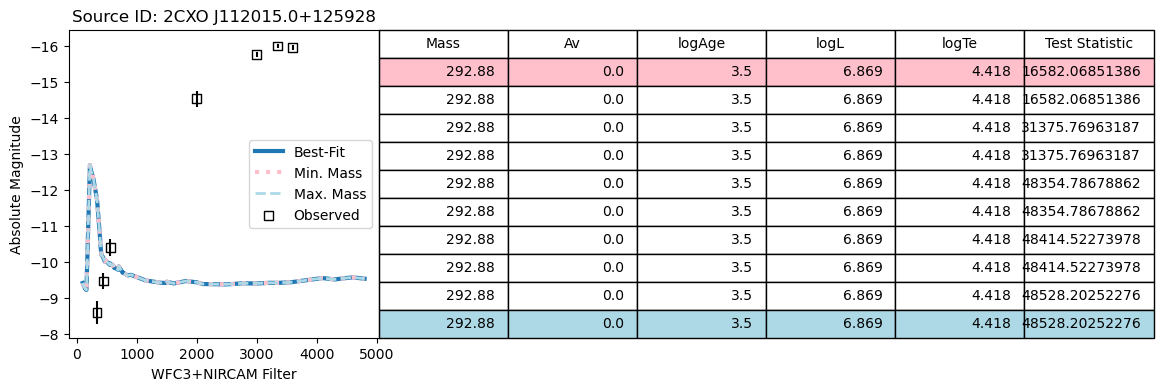

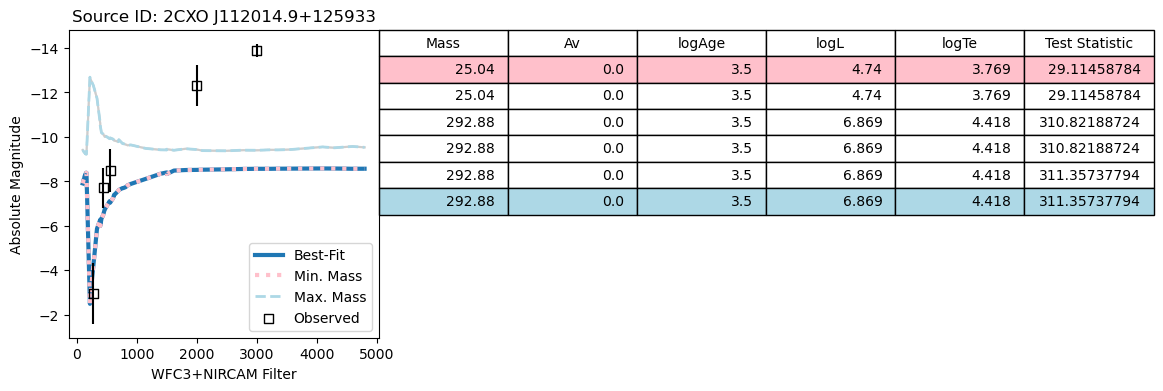

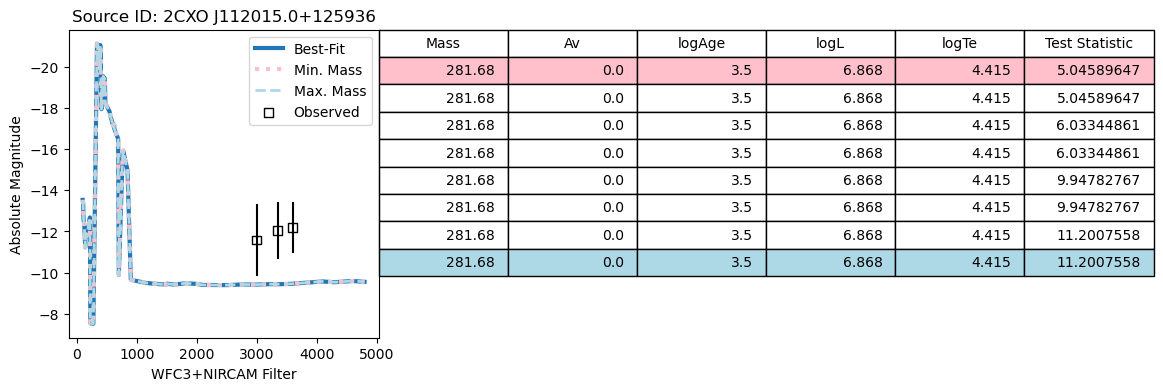

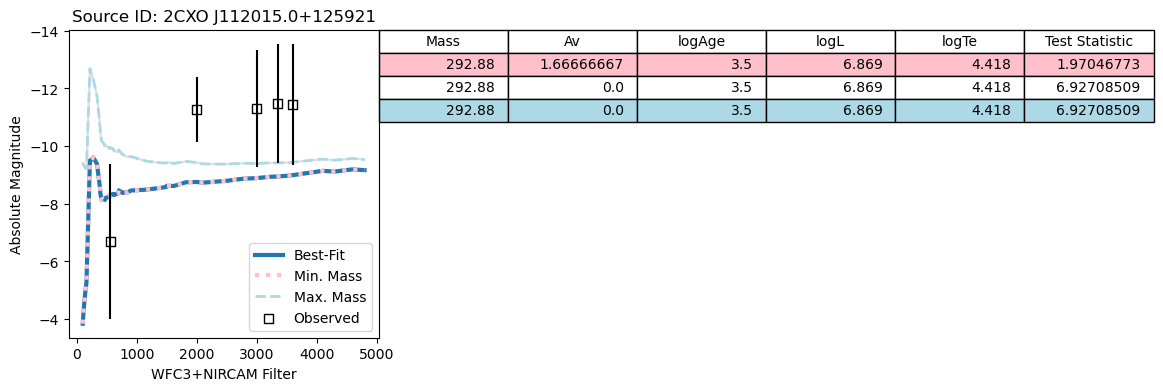

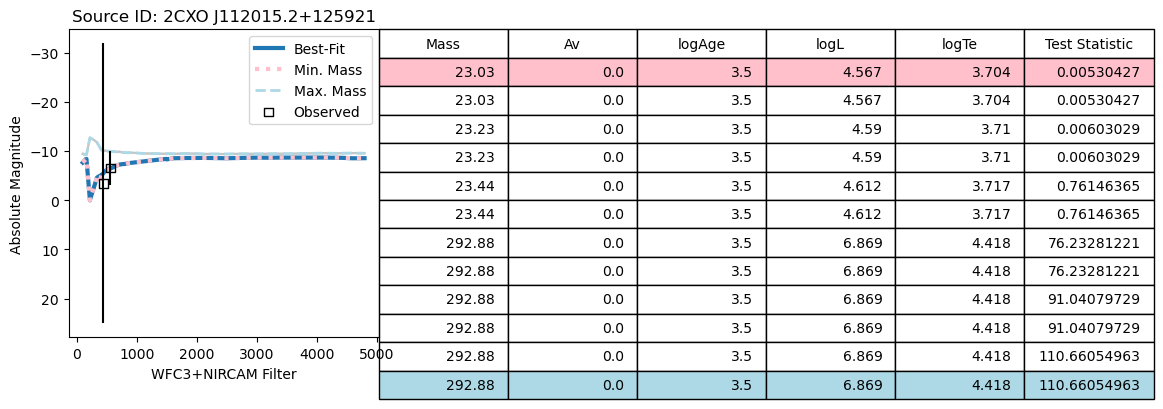

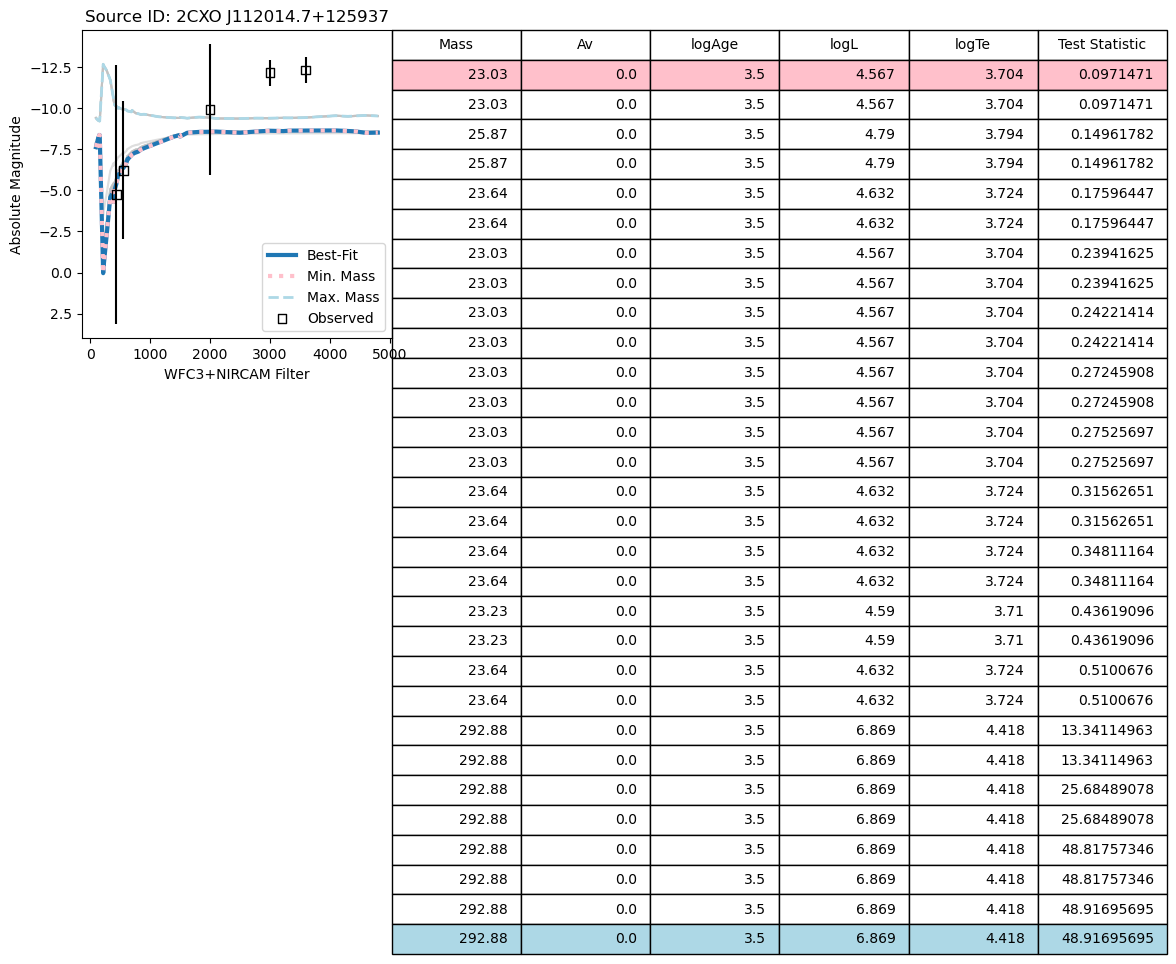

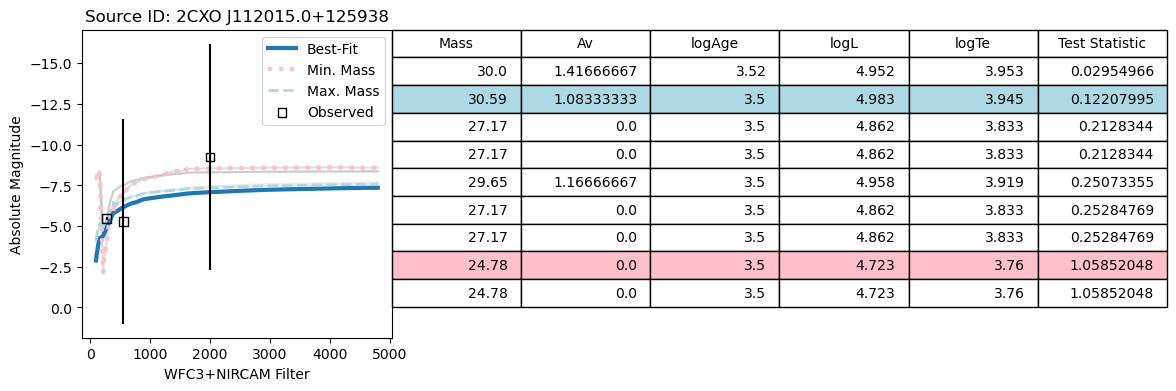

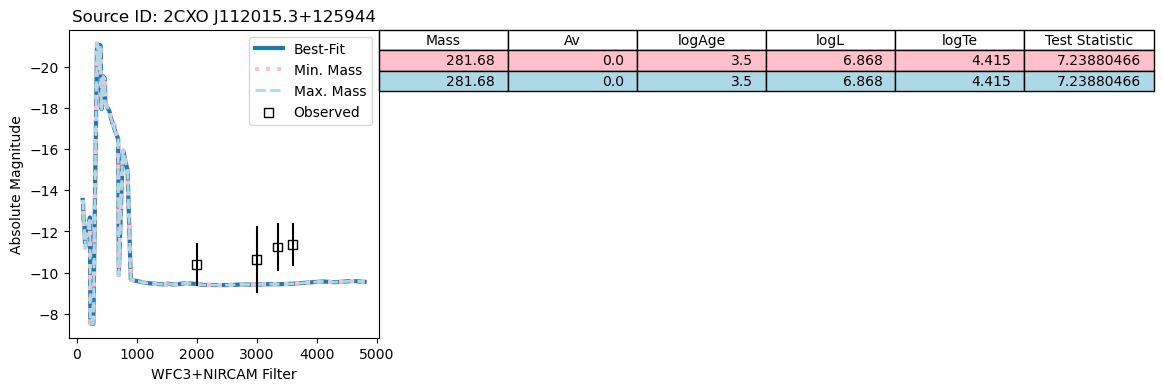

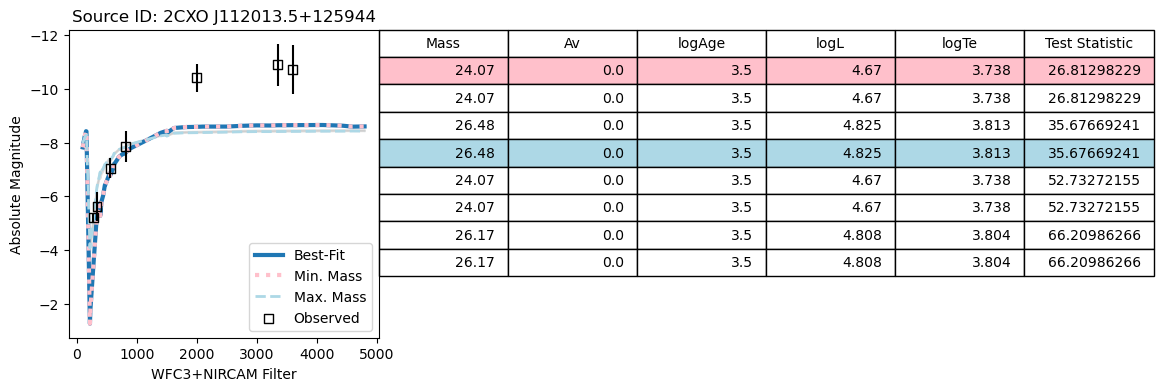

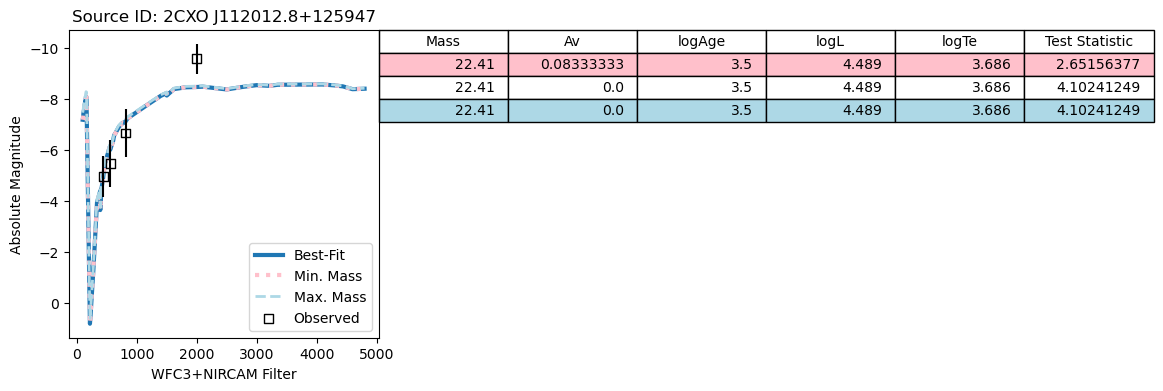

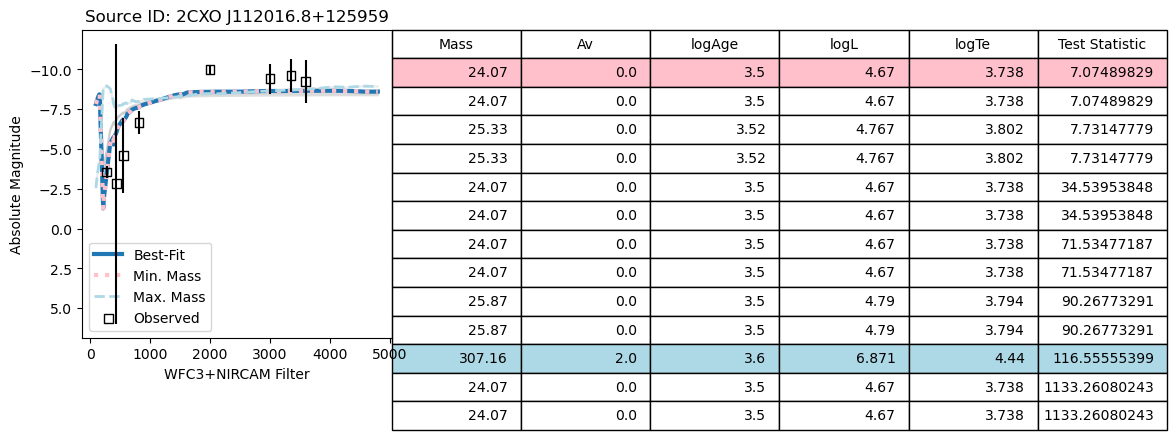

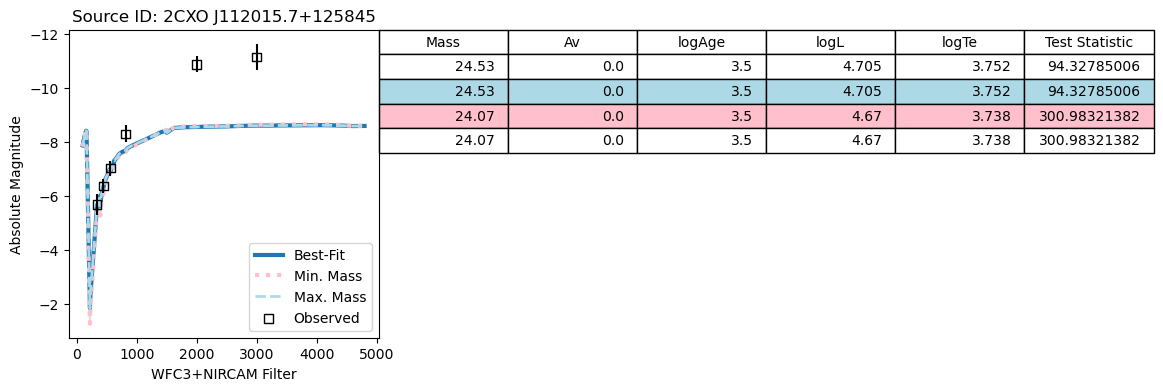

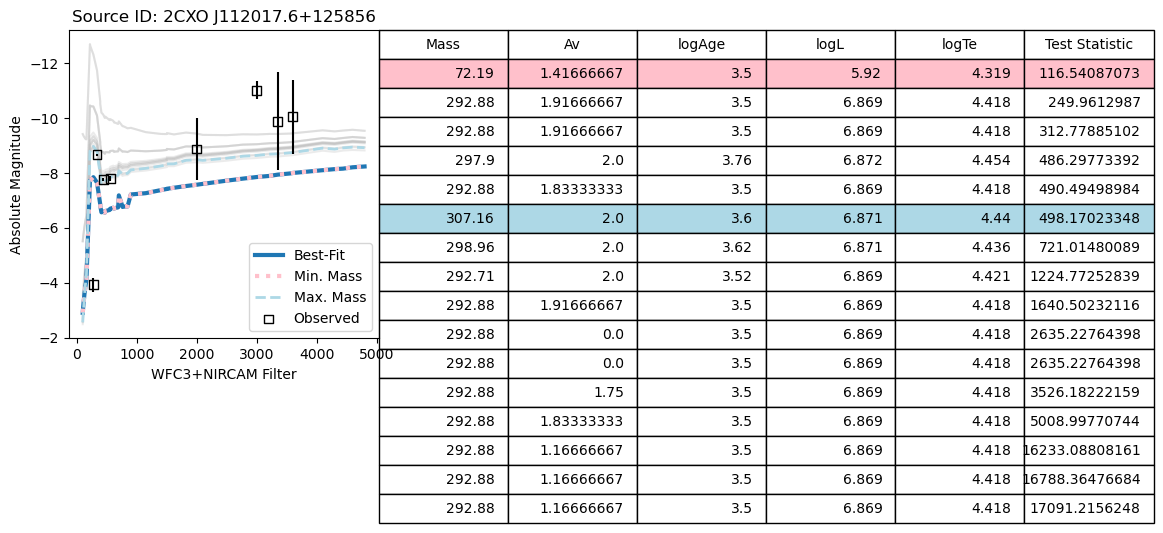

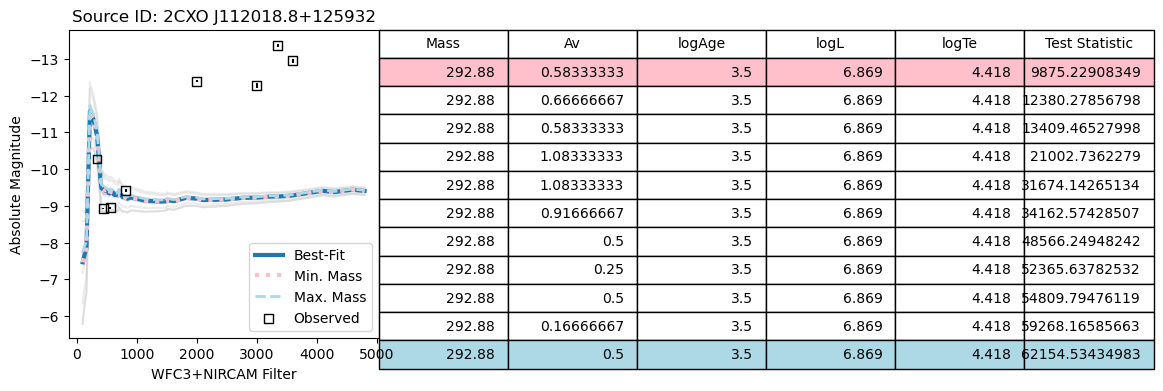

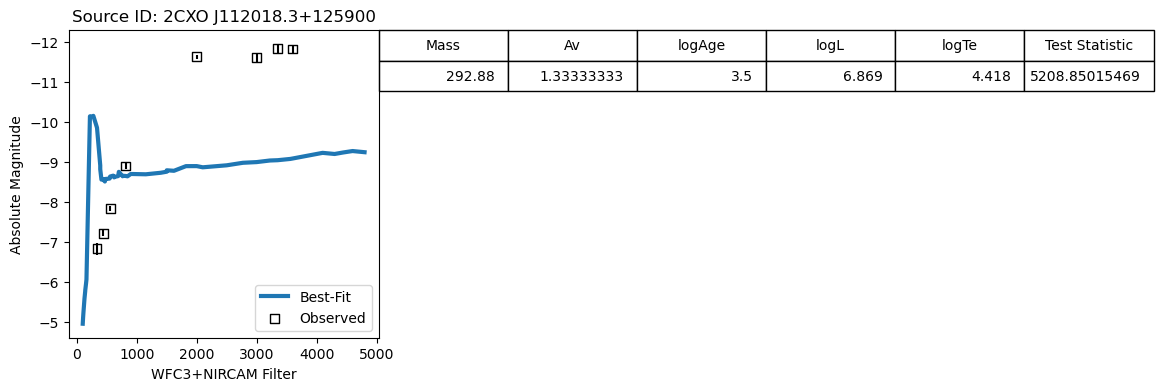

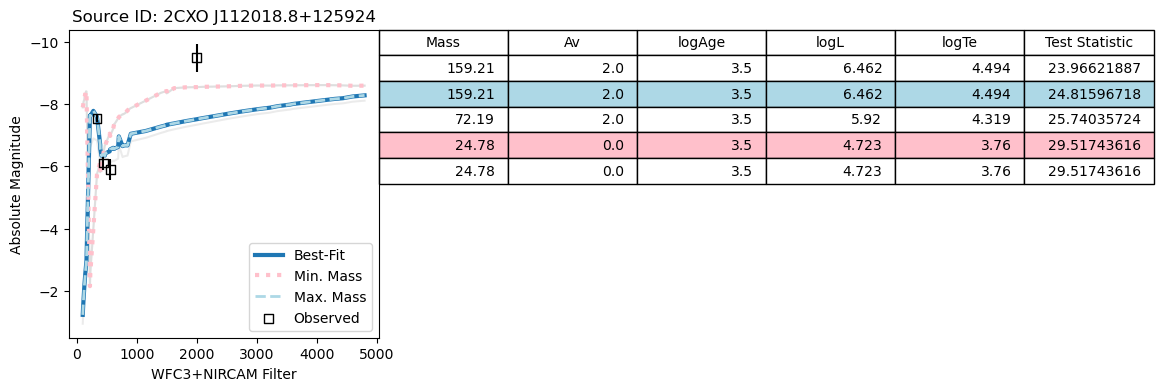

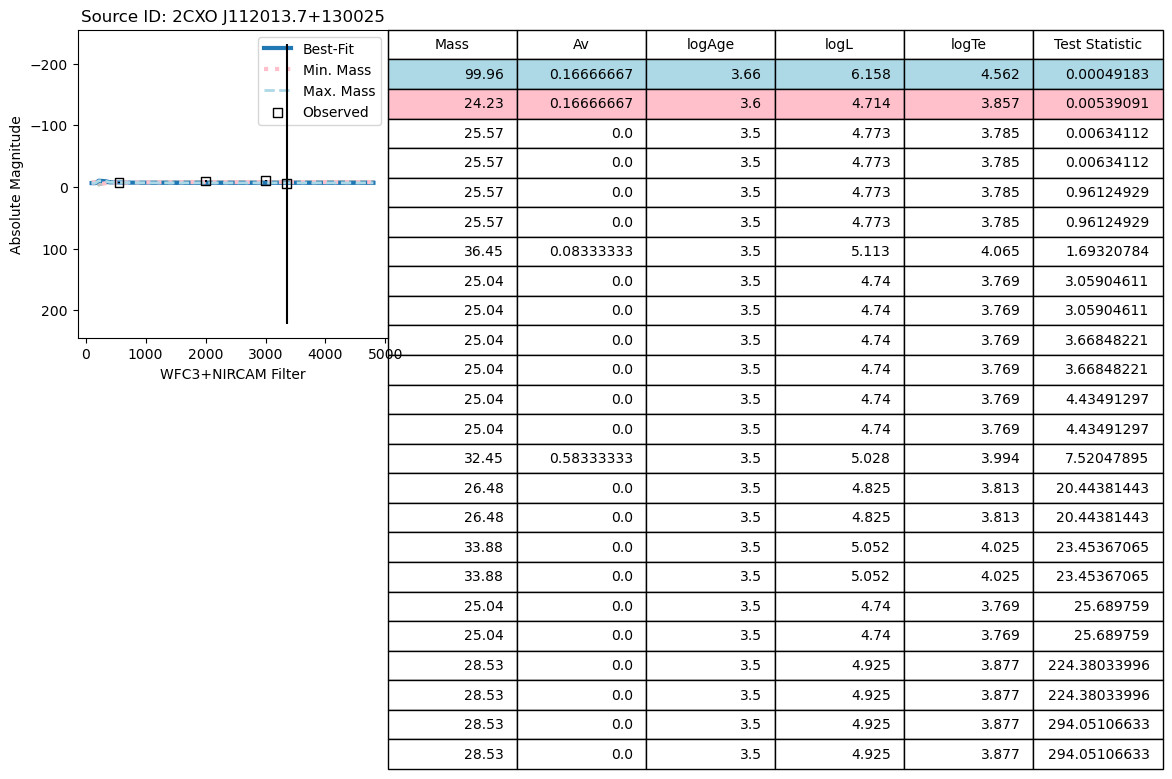

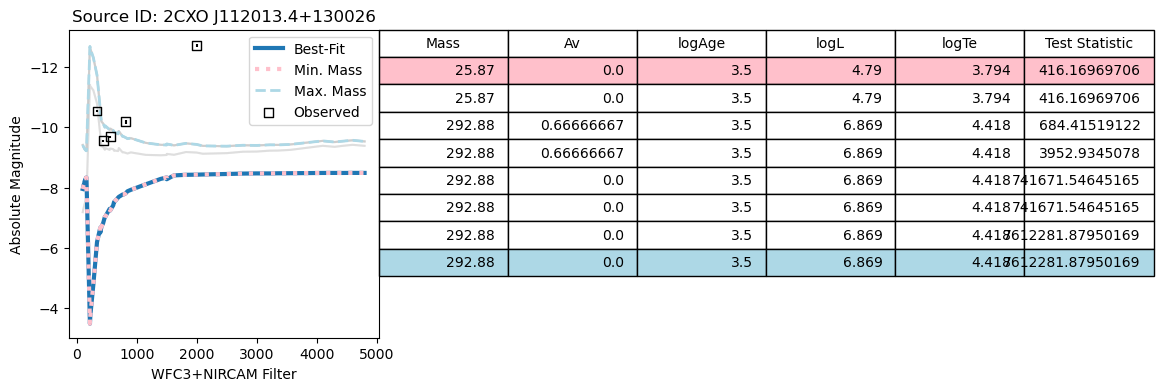

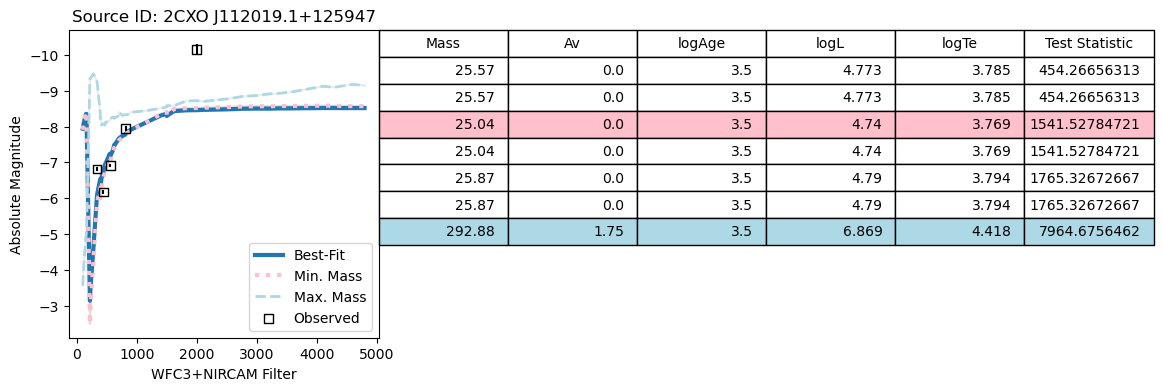

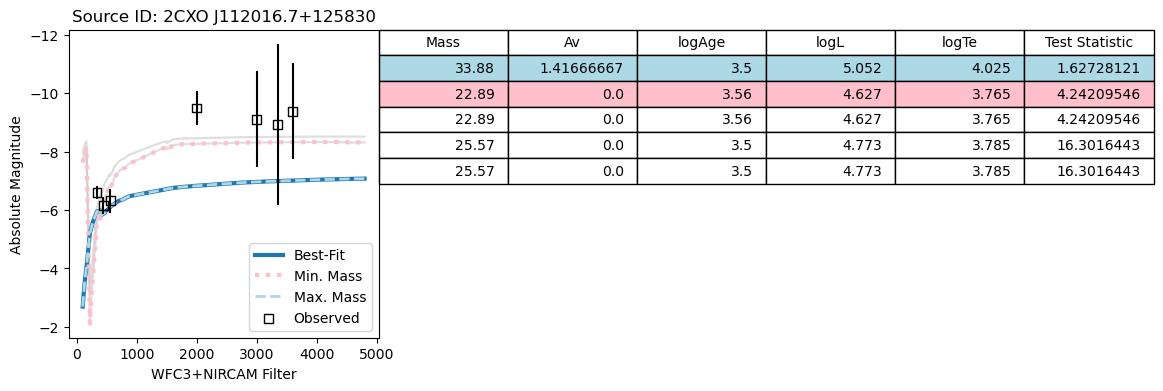

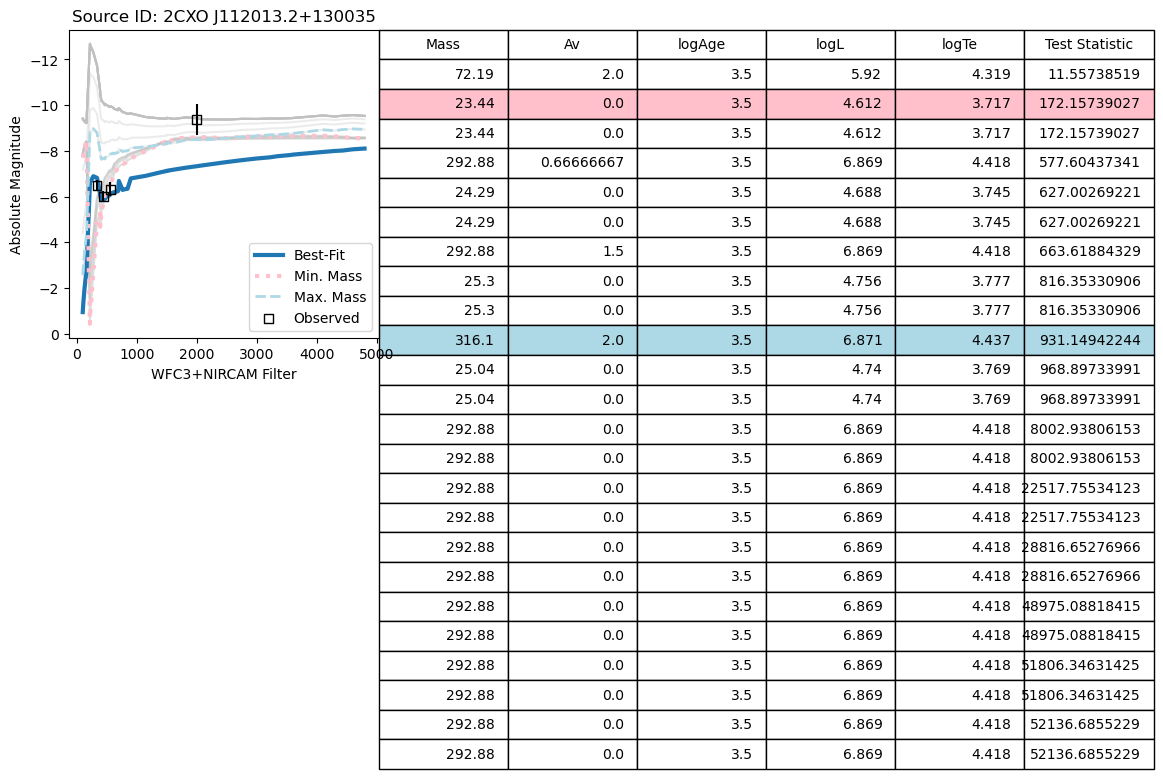

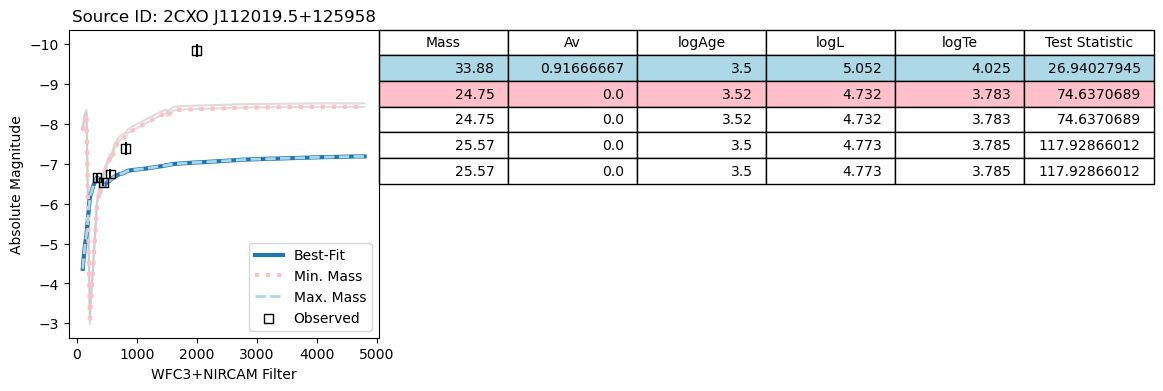

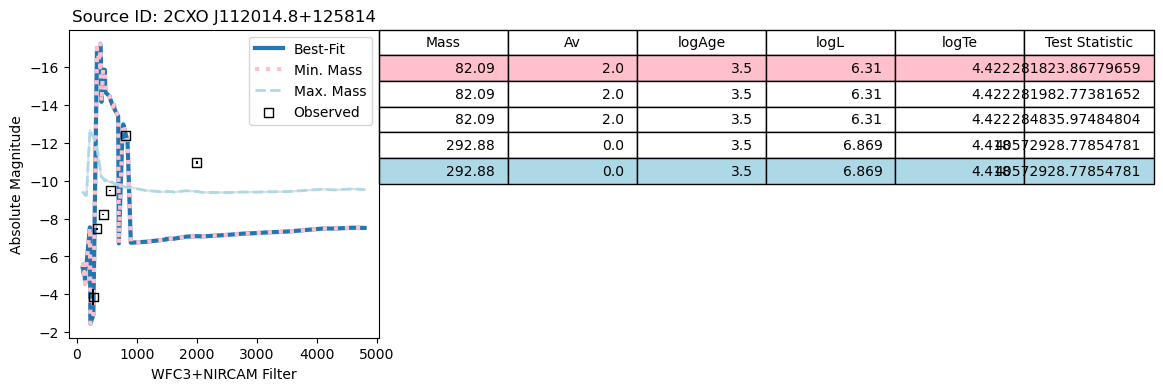

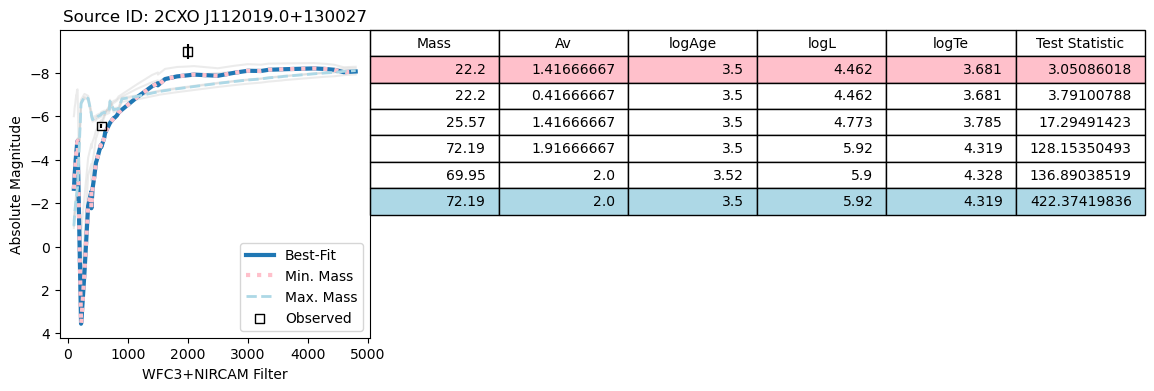

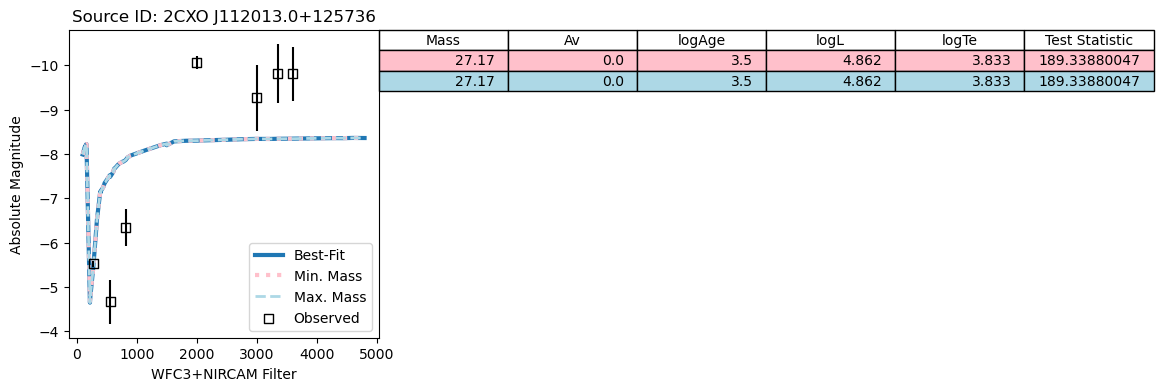

,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F3000M,F3350M,F3600M,F4100M,F4300M,F4600M,F4800M,Av,Test Statistic,CSC ID
0,0.0152,0.01508,3.66,100.000,2.63,99.96,6.158,4.562,3.478,0,...,-6.53417,-6.543949,-6.554261,-6.576154,-6.584493,-6.606315,-6.610421,0.166667,4.918344e-04,2CXO J112013.7+130025
1,0.0152,0.01508,3.50,23.027,2.63,23.03,4.567,3.704,1.001,0,...,-8.63400,-8.643000,-8.647000,-8.651000,-8.620000,-8.505000,-8.521000,0.000000,5.304269e-03,2CXO J112015.2+125921
2,0.0152,0.01508,3.50,23.027,2.63,23.03,4.567,3.704,1.001,0,...,-8.63400,-8.643000,-8.647000,-8.651000,-8.620000,-8.505000,-8.521000,0.000000,5.304269e-03,2CXO J112015.2+125921
3,0.0152,0.01508,3.60,24.234,2.63,24.23,4.714,3.857,1.489,0,...,-7.73517,-7.739949,-7.745261,-7.758154,-7.761493,-7.767315,-7.766421,0.166667,5.390909e-03,2CXO J112013.7+130025
4,0.0152,0.01508,3.50,23.231,2.63,23.23,4.590,3.710,1.007,0,...,-8.64400,-8.652000,-8.655000,-8.660000,-8.632000,-8.530000,-8.545000,0.000000,6.030290e-03,2CXO J112015.2+125921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0.0152,0.01508,3.50,350.029,2.63,292.88,6.869,4.418,2.661,0,...,-9.39900,-9.416000,-9.440000,-9.550000,-9.511000,-9.570000,-9.532000,0.000000,7.612282e+06,2CXO J112013.4+130026
223,0.0152,0.01508,3.50,350.029,2.63,292.88,6.869,4.418,2.661,0,...,-9.39900,-9.416000,-9.440000,-9.550000,-9.511000,-9.570000,-9.532000,0.000000,4.057293e+07,2CXO J112014.8+125814
224,0.0152,0.01508,3.50,350.029,2.63,292.88,6.869,4.418,2.661,0,...,-9.39900,-9.416000,-9.440000,-9.550000,-9.511000,-9.570000,-9.532000,0.000000,4.057293e+07,2CXO J112014.8+125814
225,0.0152,0.01508,3.50,27.182,2.63,27.17,4.862,3.833,1.294,0,...,-8.34100,-8.344000,-8.347000,-8.356000,-8.359000,-8.363000,-8.361000,0.000000,1.893388e+02,2CXO J112013.0+125736


In [9]:
bestfit_all = FitSED(
    df=mutual_photometry,
    instrument='wfc3+nircam',
    min_models=1,
    model_ext=True,
    idheader='CSC ID',
    plotSED=True
)

display(bestfit_all)
# mutual_bestfit.to_csv(M66_dir+"M66_dust_extinction_hst_jwst.csv", index=False)

Voila! This works! Need to create regions file now! Although, I have my suspicions that it isn't working properly as SEDs were only plotted for some sources only.

In [10]:
# Index will be used to iterate through the df
mutual_photometry['Index'] = [i for i in range(len(mutual_photometry))]
mutual_bestfit = pd.DataFrame()
no_model = []
count = 0
for index, row in mutual_photometry.iterrows():
    try:
        bestfit = FitSED(
            df=Find(mutual_photometry, f'Index = {index}'),   # mutual_photometry.iloc[[index]], this will give an error
            instrument='wfc3+nircam',
            min_models=10,
            plotSED=False,
            model_ext=True,
            idheader='CSC ID',
        )

        # Use the dataset with the smallest test statistic
        bestfit = bestfit.sort_values(by='Test Statistic')
        bestfit = bestfit.iloc[[0]]
        bestfit['RA'] = mutual_photometry['RA'][index]
        bestfit['Dec'] = mutual_photometry['Dec'][index]
        bestfit['JWST ID'] = mutual_photometry['JWST ID'][index]
        bestfit['HST ID'] = mutual_photometry['HST ID'][index]
        mutual_bestfit = pd.concat((mutual_bestfit, bestfit))
        # display(bestfit)
        count += 1
    except: # keep the code running if there's a source without a model
        no_model.append(mutual_photometry['CSC ID'][index])
        pass

print(count)
print(no_model)

Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-f

In [11]:
cols = [
        'logAge',
        'Mass',
        'Av',
        'logL',
        'logTe',
        'logg',
        'Test Statistic',
        'JWST ID',
        'HST ID',
        'CSC ID',
        'RA',
        'Dec'
    ]

absorption = mutual_bestfit.copy()[cols]
display(absorption)

,logAge,Mass,Av,logL,logTe,logg,Test Statistic,JWST ID,HST ID,CSC ID,RA,Dec
1,3.50,292.88,0.000000,6.869,4.418,2.661,31375.769632,1,1,2CXO J112015.0+125928,170.062861,12.991270
1,3.50,292.88,0.000000,6.869,4.418,2.661,16582.068514,2,1,2CXO J112015.0+125928,170.062923,12.991314
1,3.50,292.88,0.000000,6.869,4.418,2.661,48528.202523,3,1,2CXO J112015.0+125928,170.062862,12.991339
1,3.50,292.88,0.000000,6.869,4.418,2.661,48414.522740,3,2,2CXO J112015.0+125928,170.062862,12.991339
1,3.50,292.88,0.000000,6.869,4.418,2.661,48354.786789,6,2,2CXO J112015.0+125928,170.062860,12.991368
...,...,...,...,...,...,...,...,...,...,...,...,...
5,3.52,69.95,2.000000,5.900,4.328,2.647,136.890385,17,3,2CXO J112019.0+130027,170.079682,13.007607
3,3.50,72.19,1.916667,5.920,4.319,2.606,128.153505,17,4,2CXO J112019.0+130027,170.079682,13.007607
5,3.50,72.19,2.000000,5.920,4.319,2.606,422.374198,19,6,2CXO J112019.0+130027,170.079491,13.007663
3,3.50,25.57,1.416667,4.773,3.785,1.166,17.294914,23,7,2CXO J112019.0+130027,170.079599,13.007786


Now, we create regions! I do not think that it is going to be the most accurate regions because some of the regions are going to get overwritten as they have the same coordinates.

In [12]:
WriteReg(
    sources=absorption,
    outfile=M66_dir+"M66_jwst_hst_dust_extinction.reg",
    coordsys='fk5',
    coordheads=['RA', 'Dec'],
    idheader='Av',
    color='#FE6100',
    radius=0.09, 
    radunit='arcsec',
    fontsize=20
)

absorption['Av'] = absorption['Av'].round(2)

WriteReg(
    sources=absorption,
    outfile=M66_dir+"M66_jwst_hst_dust_extinction_rounded.reg",
    coordsys='fk5',
    coordheads=['RA', 'Dec'],
    idheader='Av',
    color='#FE6100',
    radius=0.09, 
    radunit='arcsec',
    fontsize=20
)

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/M66_jwst_hst_dust_extinction.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/M66_jwst_hst_dust_extinction.reg saved!
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/M66_jwst_hst_dust_extinction_rounded.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/M66_jwst_hst_dust_extinction_rounded.reg saved!


Just looked at them manually! They look pretty good! Now, we move on doing the same analysis on the best star sources!

# Best Stars

In this section, I am going to perform the same analysis that was performed above. However, the only difference is that this section will only include the SED fitting on the best stars that I chose manually.

In [3]:
hst_notes = pd.read_csv(chandra_hst_dir+"M66_XRB_notes.txt")
jwst_notes = pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt")

hmxbs_hst = Find(hst_notes, 'Class = HMXB')
hmxbs_jwst = Find(jwst_notes, 'Class = HMXB')

# common sources within the fields of HST and JWST
hmxbs_cscid = hmxbs_hst['CSC ID'].tolist() and hmxbs_jwst['CSC ID'].tolist()

hst_photometry = pd.read_csv(chandra_hst_dir+"M66_hmxbs_photometry.csv")
jwst_photometry = pd.read_csv(chandra_jwst_dir+"M66_hmxbs_photometry_jwst.csv")

In [4]:
# source in hst field but not jwst field
source = set(hmxbs_hst['CSC ID'].tolist()) ^ set(hmxbs_jwst['CSC ID'].tolist())
source

{'2CXO J112014.9+130113'}

In [5]:
# creating a dataframe with the coordinates of both HST and JWST
photometry = jwst_photometry.copy()
photometry['HST RA'] = ''
photometry['HST Dec'] = ''
photometry['HST Star ID'] = ''
photometry['F275W ID'] = ''
photometry['F336W ID'] = ''
photometry['F438W ID'] = ''
photometry['F555W ID'] = ''
photometry['F814W ID'] = ''
photometry['F275W'] = ''
photometry['F275W Err'] = ''
photometry['F336W'] = ''
photometry['F336W Err'] = ''
photometry['F438W'] = ''
photometry['F438W Err'] = ''
photometry['F555W'] = ''
photometry['F555W Err'] = ''
photometry['F814W'] = ''
photometry['F814W Err'] = ''
photometry = photometry.rename(columns={'StarID': 'JWST ID'})

for index, row in photometry.iterrows():
    for index1, row1 in hst_photometry.iterrows():
        if photometry['CSC ID'][index] == hst_photometry['CSC ID'][index1]:
            photometry['HST RA'][index] = hst_photometry['RA'][index1]
            photometry['HST Dec'][index] = hst_photometry['Dec'][index1]
            photometry['HST Star ID'][index] = hst_photometry['ID'][index1]
            photometry['F275W'][index] = hst_photometry['F275W'][index1]
            photometry['F275W Err'][index] = hst_photometry['F275W Err'][index1]
            photometry['F336W'][index] = hst_photometry['F336W'][index1]
            photometry['F336W Err'][index] = hst_photometry['F336W Err'][index1]
            photometry['F438W'][index] = hst_photometry['F438W'][index1]
            photometry['F438W Err'][index] = hst_photometry['F438W Err'][index1]
            photometry['F555W'][index] = hst_photometry['F555W Err'][index1]
            photometry['F555W Err'][index] = hst_photometry['F555W Err'][index1]
            photometry['F814W'][index] = hst_photometry['F814W'][index1]
            photometry['F814W Err'][index] = hst_photometry['F814W Err'][index1]
            photometry['F275W ID'][index] = hst_photometry['F275W ID'][index1]
            photometry['F336W ID'][index] = hst_photometry['F336W ID'][index1]
            photometry['F438W ID'][index] = hst_photometry['F438W ID'][index1]
            photometry['F555W ID'][index] = hst_photometry['F555W ID'][index1]
            photometry['F814W ID'][index] = hst_photometry['F814W ID'][index1]

# Create jwst regions file to compare with hst regions file (code below)
# to look at their degree of overlap to determine the best search radius
WriteReg(
    sources=photometry,
    outfile=chandra_jwst_dir+"M66_hmxbs_best_stars_jwst.reg",
    coordsys='fk5',
    coordheads=['RA', 'Dec'],
    idheader='JWST ID',
    color='blue',
    radius=0.09,
    radunit='arcsec',
    fontsize=17
)

WriteReg(
    sources=photometry,
    outfile=chandra_hst_dir+"M66_hmxbs_best_stars.reg",
    coordsys='fk5',
    coordheads=['HST RA', 'HST Dec'],
    idheader='HST Star ID',
    color='#FE6100',
    radius=0.09, 
    radunit='arcsec',
    fontsize=17
)

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_hmxbs_best_stars_jwst.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_hmxbs_best_stars_jwst.reg saved!
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_hmxbs_best_stars.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_hmxbs_best_stars.reg saved!


If crossref `search_radius=0.0005`, gets crossreffed with the sources in both HST and JWST.

In [6]:
best_stars = Crossref(
    df=photometry,
    regions=[chandra_hst_dir+'M66_hmxbs_best_stars.reg'],
    catalogs=['HST'],
    sourceid='JWST ID',
    search_radius=0.00005, # Using 0.00005 for most of the analysis
    coordsys='fk5',
    coordheads=['RA', 'Dec'],
    outfile=M66_dir+"M66_best_stars_jwst_hst_crossref.frame"
)

display(Find(best_stars, 'HST ID != NaN'))
print(Find(best_stars, 'HST ID != NaN')['CSC ID'].tolist())

# '2CXO J112012.8+125947': JWST and HST best stars are different


Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,RA,Dec,JWST ID,HST ID,F200W ID,F300M ID,F335M ID,F360M ID,X,Y,...,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err
0,170.062255,12.992622,4,2,194909,NaN,NaN,NaN,3112.115373,5907.603774,...,-2.726844,-1.372681,NaN,NaN,-7.463853,-0.896442,-0.973168,-0.973168,NaN,NaN
1,170.062865,12.993964,6,1,204900,NaN,NaN,NaN,3042.554415,6064.707748,...,-5.202897,-0.102546,NaN,NaN,NaN,NaN,-6.290347,-6.290347,NaN,NaN
2,170.056415,12.995653,4,1,217443,NaN,45945.0,52227.0,3778.344403,6262.444365,...,-4.975951,-0.170918,-5.364114,-0.535002,NaN,NaN,-0.364728,-0.364728,-7.607702,-0.561741
3,170.053561,12.996580,2,1,224400,NaN,NaN,NaN,4103.905660,6371.060137,...,NaN,NaN,NaN,NaN,-4.693176,-0.800427,-0.922180,-0.922180,-6.413844,-0.941390
4,170.054191,12.960178,4,1,26519,6497.0,5610.0,6873.0,4032.312552,2109.128343,...,-5.281671,-0.067507,NaN,NaN,NaN,NaN,-0.496001,-0.496001,-6.093560,-0.407560


['2CXO J112014.9+125933', '2CXO J112015.0+125938', '2CXO J112013.5+125944', '2CXO J112012.8+125947', '2CXO J112013.0+125736']


Okay, this looks amazing! Now, need to extract their photometry

In [7]:
# dataframe with the source in both HST + JWST
mutual_best_stars = Find(best_stars, 'HST ID != NaN')

photfiles = [
    jwstdir+'photometry_M66_f200w_nircam_sources.ecsv',
    jwstdir+'photometry_M66_f300m_nircam_sources.ecsv',
    jwstdir+'photometry_M66_f335m_nircam_sources.ecsv',
    jwstdir+'photometry_M66_f360m_nircam_sources.ecsv',
    hstdir+'photometry_M66_f275w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f336w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f438w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f555w_wfc3_sources.ecsv',
    hstdir+'photometry_M66_f814w_wfc3_sources.ecsv',
]

filters = [
    'F200W', 'F300M', 'F335M', 'F360M',
    'F275W', 'F336W', 'F438W', 'F555W', 'F814W'
]

idheads = [
    'F200W ID', 'F300M ID', 'F335M ID', 'F360M ID',
    'F275W ID', 'F336W ID', 'F438W ID', 'F555W ID', 'F814W ID'
]

dist = 11.32e6
dmod = 5 * np.log10(dist) - 5

best_stars_photometry = GetDaoPhots(
    df=mutual_best_stars,
    photfiles=photfiles,
    idheads=idheads,
    filters=filters,
    magheader='aperture_mag_corr',
    dmod=dmod,
    return_err=True
)

display(best_stars_photometry)
print(best_stars_photometry['CSC ID'].tolist())

Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f200w_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f300m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f335m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f360m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f275w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f336w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f438w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f555w_wfc3_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/photometry_M66_f814

,RA,Dec,JWST ID,HST ID,F200W ID,F300M ID,F335M ID,F360M ID,X,Y,...,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err
0,170.062255,12.992622,4,2,194909,NaN,NaN,NaN,3112.115373,5907.603774,...,-2.974469,-1.372681,NaN,NaN,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN
1,170.062865,12.993964,6,1,204900,NaN,NaN,NaN,3042.554415,6064.707748,...,-5.450522,-0.102546,NaN,NaN,NaN,NaN,-5.292991,-6.290347,NaN,NaN
2,170.056415,12.995653,4,1,217443,NaN,45945.0,52227.0,3778.344403,6262.444365,...,-5.223577,-0.170918,-5.611739,-0.535002,NaN,NaN,-7.046468,-0.364728,-7.855328,-0.561741
3,170.053561,12.996580,2,1,224400,NaN,NaN,NaN,4103.905660,6371.060137,...,NaN,NaN,NaN,NaN,-4.940801,-0.800427,-5.463151,-0.922180,-6.661469,-0.941390
4,170.054191,12.960178,4,1,26519,6497.0,5610.0,6873.0,4032.312552,2109.128343,...,-5.529296,-0.067507,NaN,NaN,NaN,NaN,-4.666819,-0.496001,-6.341185,-0.407560


['2CXO J112014.9+125933', '2CXO J112015.0+125938', '2CXO J112013.5+125944', '2CXO J112012.8+125947', '2CXO J112013.0+125736']


Finally, we do best fitting!

In [8]:
best_stars_photometry

,RA,Dec,JWST ID,HST ID,F200W ID,F300M ID,F335M ID,F360M ID,X,Y,...,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err
0,170.062255,12.992622,4,2,194909,NaN,NaN,NaN,3112.115373,5907.603774,...,-2.974469,-1.372681,NaN,NaN,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN
1,170.062865,12.993964,6,1,204900,NaN,NaN,NaN,3042.554415,6064.707748,...,-5.450522,-0.102546,NaN,NaN,NaN,NaN,-5.292991,-6.290347,NaN,NaN
2,170.056415,12.995653,4,1,217443,NaN,45945.0,52227.0,3778.344403,6262.444365,...,-5.223577,-0.170918,-5.611739,-0.535002,NaN,NaN,-7.046468,-0.364728,-7.855328,-0.561741
3,170.053561,12.996580,2,1,224400,NaN,NaN,NaN,4103.905660,6371.060137,...,NaN,NaN,NaN,NaN,-4.940801,-0.800427,-5.463151,-0.922180,-6.661469,-0.941390
4,170.054191,12.960178,4,1,26519,6497.0,5610.0,6873.0,4032.312552,2109.128343,...,-5.529296,-0.067507,NaN,NaN,NaN,NaN,-4.666819,-0.496001,-6.341185,-0.407560


In [9]:
# change column names to make it compatible with FitSED models
columns = {
    'F200W': 'F2000W',
    'F200W Err': 'F2000W Err',
    'F300M': 'F3000M',
    'F300M Err': 'F3000M Err',
    'F335M': 'F3350M',
    'F335M Err': 'F3350M Err',
    'F360M': 'F3600M',
    'F360M Err': 'F3600M Err',
}

best_stars_photometry = best_stars_photometry.rename(columns=columns)

In [10]:
# Index will be used to iterate through the df, giving an error the straight forward way
best_stars_photometry['Index'] = [i for i in range(len(best_stars_photometry))]
best_stars_bestfit = pd.DataFrame()
no_model = []
count = 0
for index, row in best_stars_photometry.iterrows():
    try:
        bestfit = FitSED(
            df=Find(best_stars_photometry, f'Index = {index}'),   # mutual_photometry.iloc[[index]], this will give an error
            instrument='wfc3+nircam',
            min_models=10,
            plotSED=False,
            model_ext=True,
            idheader='CSC ID',
        )
        # display(bestfit)
        # Use the dataset with the smallest test statistic
        bestfit = bestfit.sort_values(by='Test Statistic')
        bestfit = bestfit.iloc[[0]]
        bestfit['RA'] = best_stars_photometry['RA'][index]
        bestfit['Dec'] = best_stars_photometry['Dec'][index]
        bestfit['JWST ID'] = best_stars_photometry['JWST ID'][index]
        bestfit['HST ID'] = best_stars_photometry['HST ID'][index]
        best_stars_bestfit = pd.concat((best_stars_bestfit, bestfit))
        # display(bestfit)
        count += 1
    except: # keep the code running if there's a source without a model
        # no_model.append(best_stars_photometry['CSC ID'][index])
        pass

# print(count)
print(no_model)

Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
Finding best-fit model(s)...
DONE
[]


In [12]:
best_stars_bestfit

,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,F4300M,F4600M,F4800M,Av,Test Statistic,CSC ID,RA,Dec,JWST ID,HST ID
2,0.0152,0.01508,3.5,25.044,2.63,25.04,4.740,3.769,1.123,0,...,-8.579,-8.568,-8.570,0.0,29.114588,2CXO J112014.9+125933,170.062255,12.992622,4,2
0,0.0152,0.01508,3.5,27.182,2.63,27.17,4.862,3.833,1.294,0,...,-8.359,-8.363,-8.361,0.0,0.252848,2CXO J112015.0+125938,170.062865,12.993964,6,1
1,0.0152,0.01508,3.5,26.496,2.63,26.48,4.825,3.813,1.240,0,...,-8.423,-8.428,-8.425,0.0,35.676692,2CXO J112013.5+125944,170.056415,12.995653,4,1
1,0.0152,0.01508,3.5,22.411,2.63,22.41,4.489,3.686,0.997,0,...,-8.549,-8.400,-8.418,0.0,4.102412,2CXO J112012.8+125947,170.053561,12.996580,2,1
1,0.0152,0.01508,3.5,27.182,2.63,27.17,4.862,3.833,1.294,0,...,-8.359,-8.363,-8.361,0.0,189.338800,2CXO J112013.0+125736,170.054191,12.960178,4,1


In [11]:
cols = [
        'logAge',
        'Mass',
        'Av',
        'logL',
        'logTe',
        'logg',
        'Test Statistic',
        'JWST ID',
        'HST ID',
        'CSC ID',
        'RA',
        'Dec'
    ]

best_stars_absorption = best_stars_bestfit.copy()[cols]
display(best_stars_absorption)

WriteReg(
    sources=best_stars_absorption,
    outfile=M66_dir+"M66_jwst_hst_best_stars_dust_extinction.reg",
    coordsys='fk5',
    coordheads=['RA', 'Dec'],   # using JWST base coords
    idheader='Av',
    color='#FE6100',
    radius=0.09, 
    radunit='arcsec',
    fontsize=20
)

best_stars_absorption['Av'] = best_stars_absorption['Av'].round(2)

WriteReg(
    sources=best_stars_absorption,
    outfile=M66_dir+"M66_jwst_hst_best_stars_dust_extinction_rounded.reg",
    coordsys='fk5',
    coordheads=['RA', 'Dec'],   # using JWST base coords
    idheader='Av',
    color='#FE6100',
    radius=0.09, 
    radunit='arcsec',
    fontsize=20
)

,logAge,Mass,Av,logL,logTe,logg,Test Statistic,JWST ID,HST ID,CSC ID,RA,Dec
2,3.5,25.04,0.0,4.740,3.769,1.123,29.114588,4,2,2CXO J112014.9+125933,170.062255,12.992622
0,3.5,27.17,0.0,4.862,3.833,1.294,0.252848,6,1,2CXO J112015.0+125938,170.062865,12.993964
1,3.5,26.48,0.0,4.825,3.813,1.240,35.676692,4,1,2CXO J112013.5+125944,170.056415,12.995653
1,3.5,22.41,0.0,4.489,3.686,0.997,4.102412,2,1,2CXO J112012.8+125947,170.053561,12.996580
1,3.5,27.17,0.0,4.862,3.833,1.294,189.338800,4,1,2CXO J112013.0+125736,170.054191,12.960178


Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/M66_jwst_hst_best_stars_dust_extinction.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/M66_jwst_hst_best_stars_dust_extinction.reg saved!
Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/M66_jwst_hst_best_stars_dust_extinction_rounded.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/M66_jwst_hst_best_stars_dust_extinction_rounded.reg saved!
